<a href="https://colab.research.google.com/github/narejoneduet/A-University-Microgrid-Model/blob/main/To_make_them_more_resilient_to_disruptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sure, here is an example code for simulating the operation of a microgrid using Python:

In [6]:
!pip install -U python-microgrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.8 MB/s eta 0:00:00
  Created wheel for python-microgrid: filename=python_microgrid-1.4.0-py3-none-any.whl size=7725135 sha256=6be168425e5b225b8d747cf675aa0852fb6bb73a0700f76a0f2478ea035a5632
  Stored in directory: /root/.cache/pip/wheels/f0/d2/43/ae66584a5fddf2a75e29ec6e5c6c55720de3270d05e031d22d
Successfully built python-microgrid


In [16]:
import numpy as np
import pandas as pd

np.random.seed(0)

from pymgrid import Microgrid
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule)
small_battery = BatteryModule(min_capacity=10,
                              max_capacity=100,
                              max_charge=50,
                              max_discharge=50,
                              efficiency=0.9,
                              init_soc=0.2)

large_battery = BatteryModule(min_capacity=10,
                              max_capacity=1000,
                              max_charge=10,
                              max_discharge=10,
                              efficiency=0.7,
                              init_soc=0.2)
load_ts = 100+100*np.random.rand(24*90) # random load data in the range [100, 200].
pv_ts = 200*np.random.rand(24*90) # random pv data in the range [0, 200].

load = LoadModule(time_series=load_ts)

pv = RenewableModule(time_series=pv_ts)
grid_ts = [0.2, 0.1, 0.5] * np.ones((24*90, 3))

grid = GridModule(max_import=100,
                  max_export=100,
                  time_series=grid_ts)
modules = [
    small_battery,
    large_battery,
    ('pv', pv),
    load,
    grid]

microgrid = Microgrid(modules)
print(microgrid)
print(microgrid.modules.pv)
print(microgrid.modules.grid is microgrid.modules['grid'])
microgrid.controllable
print(microgrid.get_empty_action())



Microgrid([load x 1, pv x 1, balancing x 1, battery x 2, grid x 1])
[RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=2160, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used)]
True
{'battery': [None, None], 'grid': [None]}


In [41]:
for module in env.modules.module_list():
    print(f'{module}\n')

AttributeError: ignored

In [19]:
load = -1.0 * microgrid.modules.load.item().current_load
pv = microgrid.modules.pv.item().current_renewable

In [20]:
net_load = load + pv # negative if load demand exceeds pv

if net_load > 0:
    net_load = 0.0

In [21]:
battery_0_discharge = min(-1*net_load, microgrid.modules.battery[0].max_production)
net_load += battery_0_discharge

battery_1_discharge = min(-1*net_load, microgrid.modules.battery[1].max_production)
net_load += battery_1_discharge

In [22]:
grid_import = min(-1*net_load, microgrid.modules.grid.item().max_production)

In [23]:
control = {"battery" : [battery_0_discharge, battery_1_discharge],
           "grid": [grid_import]}

control

{'battery': [9.0, 7.0], 'grid': [75.20076347061497]}

In [24]:
obs, reward, done, info = microgrid.run(control, normalized=False)

In [25]:
microgrid.log.loc[:, pd.IndexSlice['load', 0, :]]

module_name           load                  
module_number            0                  
field         load_current   load_met reward
0               -154.88135  154.88135    0.0

In [26]:
microgrid.log.loc[:, pd.IndexSlice['pv', 0, :]]

module_name            pv                                        
module_number           0                                        
field         curtailment renewable_current renewable_used reward
0                     0.0         63.680587      63.680587    0.0

In [27]:
microgrid.log.loc[:, 'battery']

module_number             0                                              \
field         charge_amount current_charge discharge_amount reward  soc   
0                       0.0           20.0              9.0   -0.0  0.2   

module_number             1                                              
field         charge_amount current_charge discharge_amount reward  soc  
0                       0.0          200.0              7.0   -0.0  0.2

<Axes: >

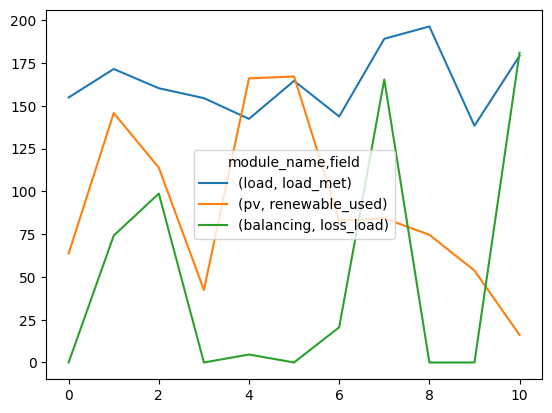

In [30]:
for _ in range(10):
    microgrid.run(microgrid.sample_action(strict_bound=True))
microgrid.log[[('load', 0, 'load_met'),
               ('pv', 0, 'renewable_used'),
               ('balancing', 0, 'loss_load')]].droplevel(axis=1, level=1).plot()

In [31]:
import pandas as pd

from matplotlib import pyplot as plt

from pymgrid import Microgrid
from pymgrid.algos import RuleBasedControl

In [32]:
microgrid = Microgrid.from_scenario(microgrid_number=0)
rbc = RuleBasedControl(microgrid)

In [33]:
rbc.reset()
rbc_result = rbc.run()

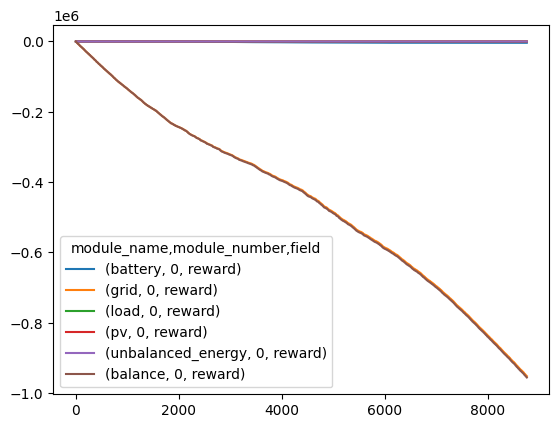

In [34]:
rbc_result.loc[:, pd.IndexSlice[:, :, 'reward']].cumsum().plot()
plt.show()

In [35]:
print(f"Total overgeneration or loss load costs over the course of the year:\n\
    {rbc_result.loc[:, pd.IndexSlice['unbalanced_energy', :, 'reward']].sum().item()}")

Total overgeneration or loss load costs over the course of the year:
    -1.8767210008263646e-10


In [36]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 31)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

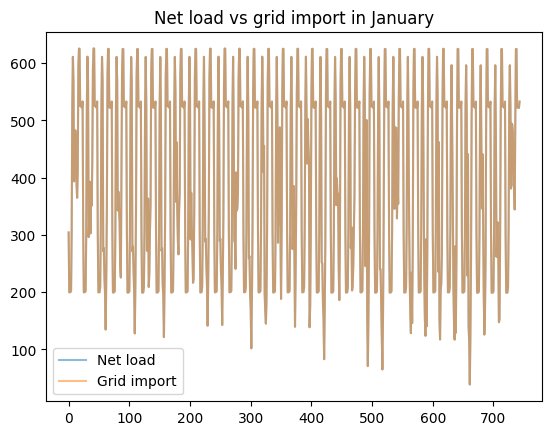

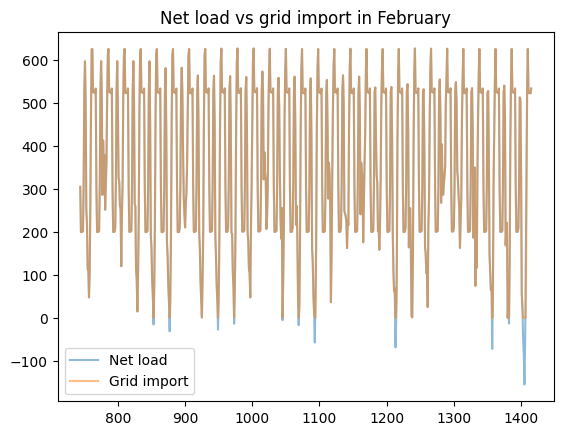

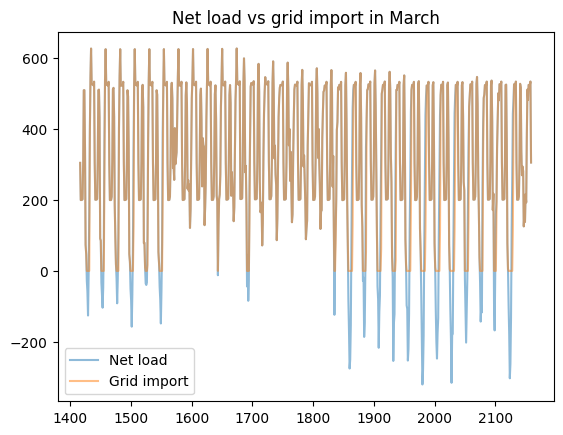

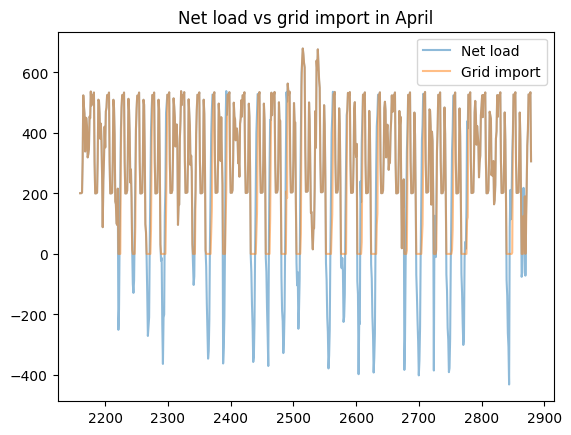

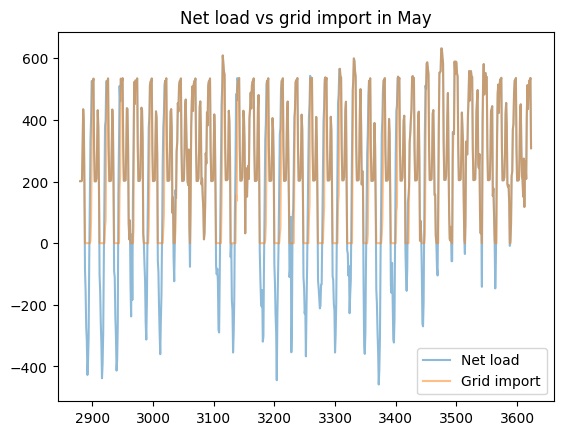

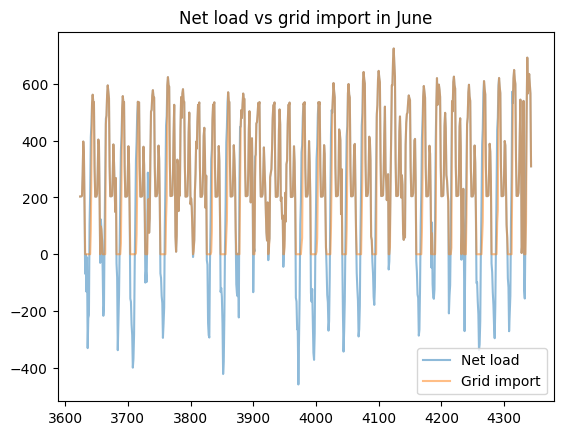

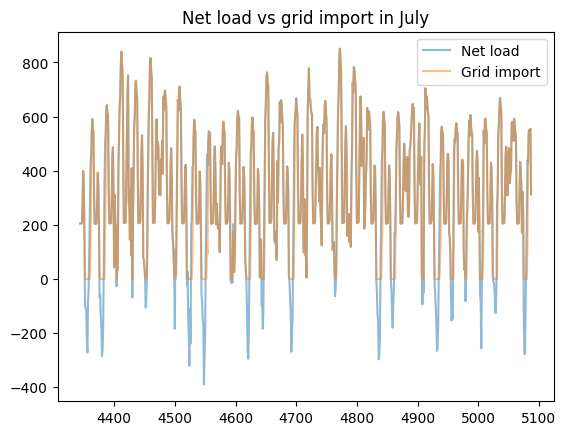

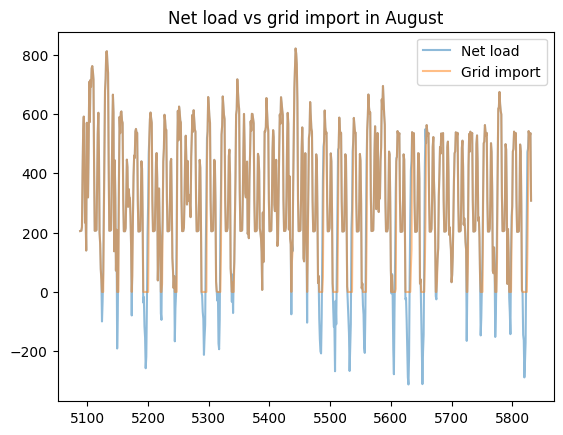

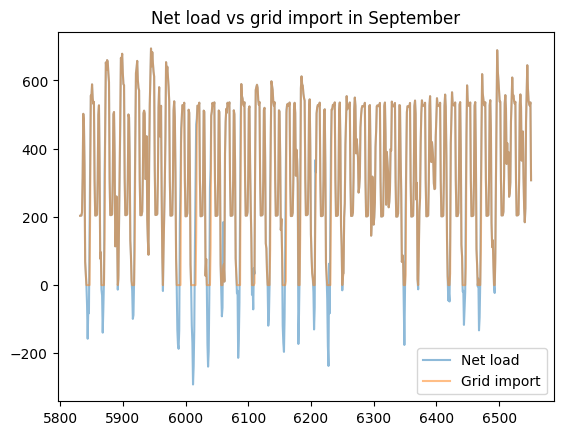

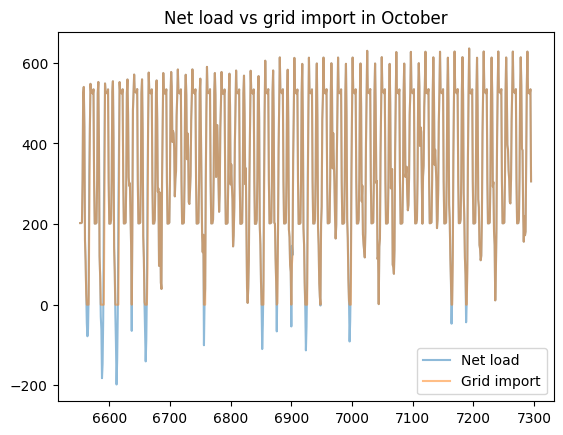

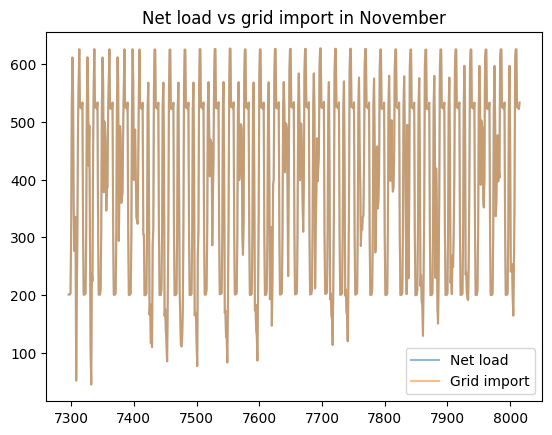

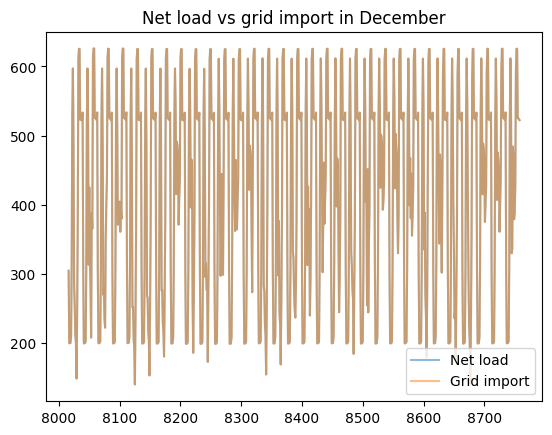

In [37]:
load_less_renewable_available = rbc_result[('load', 0, 'load_met')] - rbc_result[('pv', 0, 'renewable_current')]
grid_import = rbc_result[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

In [38]:
import pandas as pd

from pymgrid.envs import DiscreteMicrogridEnv

This code will create a simple microgrid with a generator and a load. The microgrid will be simulated for 1 hour, and the power output of the generator and the power demand of the load will be printed.

This is just a simple example, but it shows how Python can be used to simulate the operation of microgrids. More complex simulations can be created by adding more components to the microgrid, such as batteries, solar panels, and wind turbines. The simulation can also be used to test different configurations and scenarios, such as what happens if the generator fails or the load increases.

The pymgrid library is a good starting point for anyone who wants to use Python to simulate microgrids. The library provides a number of classes and functions that can be used to create and simulate microgrids. The library is also well-documented, so it is easy to get started with.